In [61]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from trajectory.segments import * 
from trajectory.planner import * 
from trajectory.plot import * 
from trajectory.trapmath import * 
import matplotlib.pyplot as plt
from IPython.display import display
import trajectory as tj
import pandas as pd
from math import sqrt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Test the error of the inital_parameters() function

from trajectory.planner import accel_tx, v_c_max, max_v0_for_x, inital_parameters

from random import randint, random


rows = []
for i in range(10000):
    v_max = randint(300,10000)
    a_max = randint(v_max*15,v_max*25)
    
    x = randint(10,v_max)
    v_0 = randint(0,v_max)
    v_1 = randint(0,v_max)
    
    args = (x, v_0, v_max, v_1, a_max)
    r = inital_parameters(*args)

    d = { k:v for k,v in zip('x_in v_0_in v_c_in v_1_in a_max'.split(),args)}
    d.update(r._asdict())
    rows.append(d)
        
df = pd.DataFrame(rows)
df['x_r'] = df.x_a + df.x_c + df.x_d
df['eq'] = df.x_in == df.x_r
df['err'] =  ((df.x_in - df.x_r).abs()/df.x_in) 
t = df[ (df.is_triangle==True) & (df['eq'] == False) ].copy()


assert df.err.mean() < .001 # Less than .1 %
df.err.mean()

0.0006517799392025516

In [9]:
# Run 1000 random moves on 6 joints

import datetime

N = 1000

sl = SegmentList([Joint(5_000, 50_000),
                  Joint(10_000, 200_000),
                  Joint(10_000, 20_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000),
                  Joint(5_000, 50_000)
                 ]
                )


moves = [ [randint(-2000,2000) for _ in sl.joints] for i in range(N) ]

start = datetime.datetime.now()

for move  in moves:
    
    try:
        sl.rmove(move)
    except Exception as e:
        print(move)
        raise


finish = datetime.datetime.now()
print( (finish-start)/N)

#plot_segment_list(sl.dataframe)
#sl.dataframe.sample(10)

[-1112, 638, -917, 677, 1667, 1314]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/eric/opt/anaconda3/envs/robot/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kp/jn04x74j43j9v0t6cl0574h00000gn/T/ipykernel_78246/3202738358.py", line 24, in <cell line: 21>
    sl.rmove(move)
  File "/Users/eric/Documents/proj/trajectory/trajectory/planner.py", line 939, in rmove
    self.update(s)
  File "/Users/eric/Documents/proj/trajectory/trajectory/planner.py", line 967, in update
    s.update()
  File "/Users/eric/Documents/proj/trajectory/trajectory/planner.py", line 745, in update
    self.update_initial_parameters()
  File "/Users/eric/Documents/proj/trajectory/trajectory/planner.py", line 765, in update_initial_parameters
    s.update_initial_parameters(self.t)
  File "/Users/eric/Documents/proj/trajectory/trajectory/planner.py", line 347, in update_initial_parameters
    p = max_v1(self.x, t, v_0, self.joint.v_ma

In [10]:
# Test random segments, without segment-to-segment interactions

N = 20

inputs = []

joints = [Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)]
sl = SegmentList(joints)   

for i in range(N):
    moves = [randint(-2000,2000) for _ in sl.joints] 

    limits = []
    for j in sl.joints:
        v_0_max = randint(0,j.v_max)
        v_0 = randint(0,j.v_max)
        v_1_max = randint(0,j.v_max)
        limits.append( (v_0_max, v_0 , v_1_max) )
        
    inputs.append( (moves, limits) )
      

In [12]:
        
frames = []

def test_sl(moves, limits):
    from trajectory.planner import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    s = sl.rmove(moves)  
    
    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max
        
    s.update()
    
    sl.validate()
    
    return s


for i, (moves, limits) in enumerate(inputs):

    try:
        s = test_sl(moves, limits)
        
        v_0_in = [e[1] for e in limits]
        v_0_out = [js.v_0 for js in s]
        
        frames.append(s.params)
    except Exception as e:
        print('E ', type(e), i, e)

df = pd.concat(frames)
df[df.err_x > 1].sort_values('err_x', ascending=False)

,seg,js,seg_t,x,t,dir,v_0_max,v_0,x_a,t_a,...,v_c_max,v_c,x_d,t_d,v_1,v_1_max,calc_x,sum_x,calc_t,err_x
2,0,2,0.3492,1246,0.3492,-1,398,398,148.285129,0.06947,...,5000,3929,22.348759,0.00601,3571,3571,1248,1246,0.348234,2.1621
2,0,2,0.4002,1501,0.4002,1,113,113,170.547967,0.08037,...,5000,4174,48.874657,0.01283,3490,3490,1503,1501,0.399320,2.0090
0,0,0,0.3248,1124,0.3248,1,1746,483,139.689839,0.06571,...,5000,3799,0.000000,0.00000,3799,4836,1125,1124,0.324331,1.0035


,t,seg,axis,x,v0m,v_i,v_f,v1m,ss,del_t,calc_x,err
0,0.100000,0,0,250.0,5000,5000.00,0.00,0,a,0.100000,250.000000,0.000000
1,0.700000,0,0,0.0,5000,0.00,0.00,0,c,0.600000,0.000000,0.000000
2,0.700000,0,0,0.0,5000,0.00,0.00,0,d,0.000000,0.000000,0.000000
3,0.008333,0,1,40.0,5000,5000.00,4279.62,5000,a,0.008333,38.664929,1.335071
4,0.700000,0,1,2960.0,5000,4279.62,4279.62,5000,c,0.691667,2960.070643,-0.070643
5,0.700000,0,1,0.0,5000,4279.62,4279.62,5000,d,0.000000,0.000000,0.000000


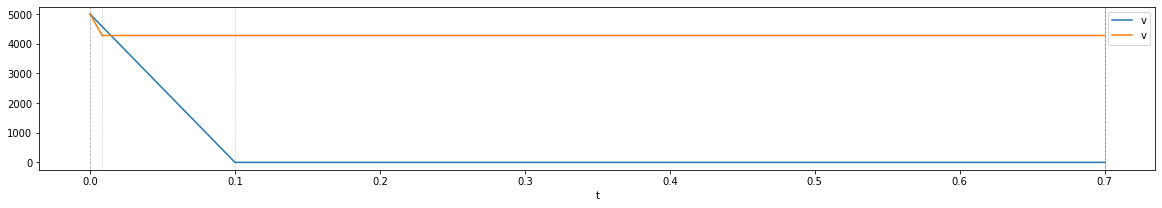

In [14]:
from trajectory.planner import max_v0_for_x

def run_segment(moves, limits, update=True):
    from trajectory.planner import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    
    s = sl.rmove(moves, update = update)  

    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max   
    
    return sl


sl = run_segment([250,3000], [(5000, 5000, 0), (5000, 5000, 5000)], False)
sl.update()

plot_segment_list(sl.dataframe)
sl.dataframe

,t,seg,axis,x,v0m,v_i,v_f,v1m,ss,del_t,calc_x,err
0,0.014286,0,0,5.0,0,0.00,729.48,0,a,0.014286,5.210566,-0.210566
1,0.685714,0,0,490.0,0,729.48,729.48,0,c,0.671429,489.793735,0.206265
2,0.700000,0,0,5.0,0,729.48,0.00,0,d,0.014286,5.210566,-0.210566
3,0.008333,0,1,40.0,5000,5000.00,4583.33,0,a,0.008333,39.930382,0.069618
4,0.608333,0,1,2750.0,5000,4583.33,4583.33,0,c,0.600000,2749.998000,0.002000
5,0.700000,0,1,210.0,5000,4583.33,0.00,0,d,0.091667,210.069368,-0.069368


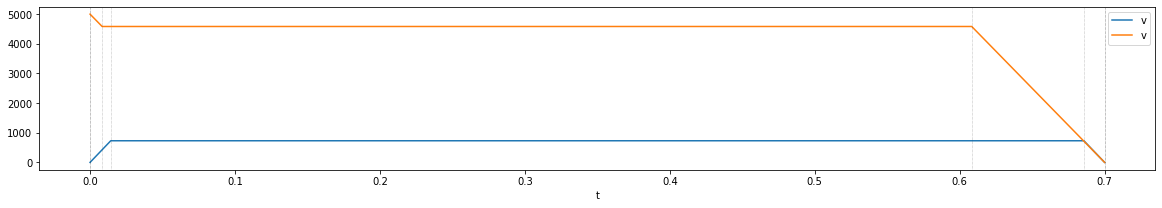

In [15]:
sl = run_segment([500,3000], [(0, 0, 0), (5000, 5000, 0)])
sl.update()
plot_segment_list(sl.dataframe)
sl.dataframe


# Classification

In [16]:
from collections import defaultdict
from random import shuffle
from trajectory.planner import classify, kind_icon_map


# Make new classification tests
dd = defaultdict(set)
for _ in range(10_000):
    x = max(randint(-500,1000), 0)
    v_0 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    v_1 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    args = (x, v_0, v_1, *av)
    r = classify(*args)
    
    dd[r].add(args)

# Make the class_test list
l = []
for k, s in dd.items():
    s = list(s)
    shuffle(s)
    for v in s[:10]:
        l.append((v,k.name))
  
# Create a map from each classification to a set
# of values that has the (min, max) values for each parameter that produce that
# classification
min_max = {}
rows  = []
arg_names = 'x v_0 v_1 v_max, a_max'.split()
for k, s in dd.items():
    z = list(zip(*list(s)))
    z_min = [min(e) for e in z]
    z_max = [max(e) for e in z]
    
    min_max[k] =  list(zip(z_min, z_max))[:3]
    
    d = { 'name': k.name }
    for arg, mn, mx in list(zip(arg_names, z_min, z_max))[:3]:
        d[arg+'_min'] = mn
        d[arg+'_max'] = mx
    
    rows.append(d)
    
min_max_df = pd.DataFrame(rows)
min_max_df


,name,x_min,x_max,v_0_min,v_0_max,v_1_min,v_1_max
0,ZERO,0,0,0,5000,0,5000
1,PENTAGON,1,1000,2,5000,3,5000
2,ACEL,3,1000,0,0,8,5000
3,DECEL,1,250,423,5000,0,0
4,CLIFF,34,1000,2,5000,0,0
5,TRAPZEZOID,500,1000,0,0,0,0
6,TRIANGLE,1,495,0,0,0,0
7,TROUGH,1,247,3,5000,5,5000


In [37]:
#  (x, v_0, v_1, v_max, a_max) 
class_test = [
 ((991, 3270, 2029, 5000, 50000), 'PENTAGON'),
 ((491, 4113, 5000, 5000, 50000), 'PENTAGON'),
 ((646, 3407, 4052, 5000, 50000), 'PENTAGON'),
 ((985, 1309, 4067, 5000, 50000), 'PENTAGON'),
 ((944, 4496, 1129, 5000, 50000), 'PENTAGON'),
 ((606, 2337, 2051, 5000, 50000), 'PENTAGON'),
 ((514, 1783, 2992, 5000, 50000), 'PENTAGON'),
 ((560, 3763, 556, 5000, 50000), 'PENTAGON'),
    
 ((4000, 0, 0, 5000, 50000), 'TRAPZEZOID'),
 ((546, 0, 0, 5000, 50000), 'TRAPZEZOID'),
    
 ((173, 3548, 3826, 5000, 50000), 'TROUGH'),
 ((188, 4335, 425, 5000, 50000), 'TROUGH'),
 ((30, 1732, 1732, 5000, 50000), 'TROUGH'),
 ((25, 1581, 1581, 5000, 50000), 'TROUGH'),
 ((7, 405, 836, 5000, 50000), 'TROUGH'),
 ((13, 765, 1140, 5000, 50000), 'TROUGH'),
 ((1, 316, 316, 5000, 50000), 'TROUGH'),
 ((10, 1000, 1000, 5000, 50000), 'TROUGH'),
    
 ((289, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((369, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((71, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((252, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((305, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((133, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((390, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((434, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((231, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((281, 0, 0, 5000, 50000), 'TRIANGLE'),
    
 ((629, 0, 3151, 5000, 50000), 'ACEL'),
 ((918, 0, 4129, 5000, 50000), 'ACEL'),
 ((299, 0, 1317, 5000, 50000), 'ACEL'),
 ((576, 0, 570, 5000, 50000), 'ACEL'),
 ((784, 0, 2494, 5000, 50000), 'ACEL'),
 ((393, 0, 188, 5000, 50000), 'ACEL'),
 ((618, 0, 4152, 5000, 50000), 'ACEL'),
 ((862, 0, 1289, 5000, 50000), 'ACEL'),
 ((71, 0, 1392, 5000, 50000), 'ACEL'),
 ((123, 0, 3507, 5000, 50000), 'ACEL'),
    
 ((545, 441, 0, 5000, 50000), 'CLIFF'),
 ((987, 3106, 0, 5000, 50000), 'CLIFF'),
 ((836, 2502, 0, 5000, 50000), 'CLIFF'),
 ((418, 558, 0, 5000, 50000), 'CLIFF'),
 ((559, 904, 0, 5000, 50000), 'CLIFF'),
 ((202, 1662, 0, 5000, 50000), 'CLIFF'),
 ((270, 5000, 0, 5000, 50000), 'CLIFF'),
 ((257, 1856, 0, 5000, 50000), 'CLIFF'),
 ((381, 3522, 0, 5000, 50000), 'CLIFF'),
 ((869, 2426, 0, 5000, 50000), 'CLIFF'),
    
 ((115, 5000, 0, 5000, 50000), 'DECEL'),   
 ((25, 1785, 0, 5000, 50000), 'DECEL'),
 ((53, 5000, 0, 5000, 50000), 'DECEL'),
 ((35, 2898, 0, 5000, 50000), 'DECEL'),
 ((66, 4563, 0, 5000, 50000), 'DECEL'),
 ((100, 4458, 0, 5000, 50000), 'DECEL'),
 ((87, 5000, 0, 5000, 50000), 'DECEL'),
 ((42, 4511, 0, 5000, 50000), 'DECEL'),
    
 ((0, 0, 3438, 5000, 50000), 'ZERO'),
 ((0, 4255, 4443, 5000, 50000), 'ZERO'),
 ((0, 2960, 2762, 5000, 50000), 'ZERO'),
 ((0, 259, 116, 5000, 50000), 'ZERO'),
 ((0, 326, 1424, 5000, 50000), 'ZERO'),
 ((0, 3923, 0, 5000, 50000), 'ZERO'),
 ((0, 0, 3739, 5000, 50000), 'ZERO'),
 ((0, 4587, 1189, 5000, 50000), 'ZERO'),
 ((0, 2137, 5000, 5000, 50000), 'ZERO'),
 ((0, 2911, 0, 5000, 50000), 'ZERO')]

# These record produce a high x error when 
# recalculating the area
class_test_he = [
 ((193, 1018, 4588, 5000, 50000), 'TROUGH'), 
 ((233, 1029, 2812, 5000, 50000), 'TROUGH'), 
 ((218, 3779, 0, 5000, 50000), 'DECEL'),
 ((109, 2709, 0, 5000, 50000), 'DECEL')
]

In [38]:
output = []
for args, name in class_test:
    assert classify(*args).name == name,  (classify(*args).name, name)
    output.append( (args,  classify(*args).name) )


In [68]:
# Check that initial_parameters prodices reasonable values for 
# many conditions.
from trajectory.trapmath import ShortTimeError

for args, name in class_test:
    (x, v_0, v_1, v_max, a_max) = args
    
    p = inital_parameters(x, v_0, v_max, v_1, a_max, t=None)
    
    x_ = penta_area(p.t, p.v_0, p.v_c, p.v_1, a_max)
              
    if x > 0  and v_1 != p.v_1:
        print (name, args, v_1, p.v_1 )

    try:
        v_c = penta_v_c(x, p.t, v_0, v_1, a)
        
        if round(v_c) != round(p.v_c):
            #print(name, v_c)
            pass
        
    except ValueError as e:
        print(name, e, p.v_c, x, p.t)
    except ShortTimeError:
        pass
        #print("Short!")


    
    

!!! 141.60037575187351 282.7248916728981 0.10634376176774979 0.07525965074377465
ACEL math domain error 3975.5940441937446 299 0.1326837617677498
!!! 360.71044002749886 721.4207212666842 0.16987297857713382 0.12011834831157127
ACEL math domain error 4434.824464428346 393 0.17363297857713383
!!! 11.458014942980228 20.81443097912567 0.02885441455245673 0.02140842352251116
ACEL math domain error 2113.360363811418 71 0.05669441455245673
!!! 324.923017132223 649.834523254552 0.1612246287952994 0.11400403802185657
CLIFF math domain error 4588.615719882485 418 0.1723846287952994
!!! 60.01710855871106 118.3667414415183 0.06880893588525208 0.048996778897683085
CLIFF math domain error 3382.223397131302 202 0.10204893588525209
!!! 77.43706524233966 152.83123320078892 0.0781872708823601 0.05565503220458673
CLIFF math domain error 3810.6817720590025 257 0.1153072708823601


In [40]:

# Test case, trivial trapezoid
t, v_0, v_c, v_1, a = (.5, 0, 4000, 0, 50_000)
x = penta_area(t, v_0, v_c, v_1, a)
tt_t, tt_x, v_max = simplify_pentagon(x, t, v_0, v_c, v_1, a)
assert tt_t == t and tt_x == x and v_max == 0

In [126]:
a_max = 50_000
p = inital_parameters(1000, 0, 2000, 0, a_max)
p

Params(t=0.54, x=1000.0, t_a=0.04, t_c=0.46, t_d=0.04, x_a=40.0, x_c=920.0, x_d=40.0, v_0=0, v_c=2000, v_1=0, is_triangle=False, input=InputParams(x=1000.0, v_0=0, v_c=2000, v_1=0, a_max=50000, t=None))

In [133]:
def trap_v_c
x_f = a_max * p.t ** 2 / 4  # Area of the whole triangle. Our x is the trap at the bottom
x_t = x_f - p.x # Area of the triangle above our trapezoid
t_c = sqrt(4*x_t/a_max) # t_c is both the total time for the top triangle, and the cruise time for our trap

t_a = t_d = (p.t - t_c)/2 # acelleration and decel times
v_c = a_max * t_a # v_c is at the end of the acel time



(2000.0000000000005, 0.46, 0.04000000000000001)

In [128]:
penta_area(p.t, 0, v_c, 0, a_max)

2471.4879999999994

In [129]:
x_f, x_t

(3645.0000000000005, 2645.0000000000005)